100%|██████████| 170M/170M [00:02<00:00, 77.2MB/s]


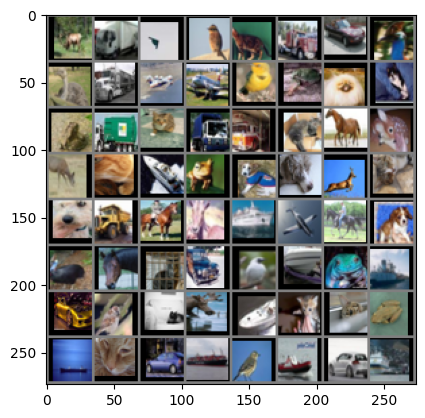

In [1]:
## Original Code
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset with data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally
    transforms.RandomCrop(32, padding=4), # Randomly crop the image with padding
    transforms.ToTensor(),                # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Display a batch of augmented images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images))



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.QSO4I8_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.QSO4I8_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


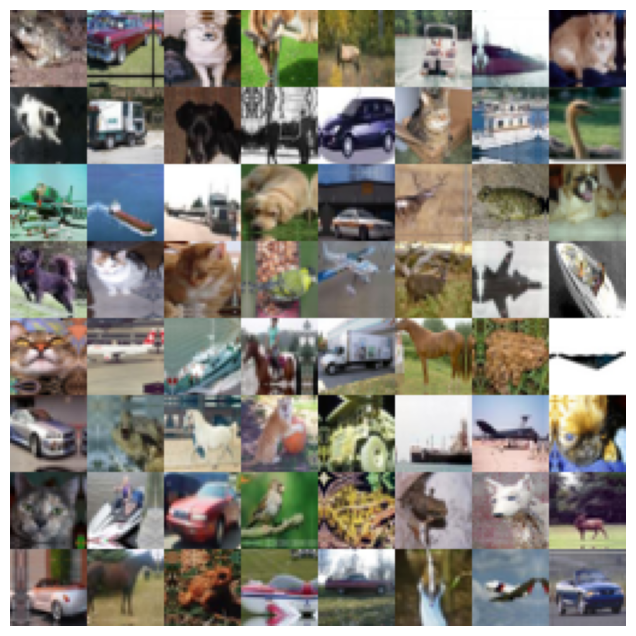

In [2]:
## Strong LLM
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# -----------------------------
# Augmentation Functions in JAX
# -----------------------------
def random_flip(image, key):
    """Randomly flip the image horizontally with probability 0.5."""
    do_flip = jax.random.uniform(key) > 0.5
    return jnp.where(do_flip, jnp.flip(image, axis=1), image)

def random_crop(image, key, crop_size=32, padding=4):
    """Pad the image then randomly crop a patch of size (crop_size x crop_size)."""
    # Pad with 4 pixels on each side using reflection (mimics PyTorch padding behavior)
    image_padded = jnp.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='reflect')
    # The padded image has size 32+8=40; choose a random crop location in the padded image.
    max_offset = padding * 2  # 8
    offset_x = jax.random.randint(key, (), 0, max_offset + 1)
    offset_y = jax.random.randint(key, (), 0, max_offset + 1)
    cropped = image_padded[offset_x:offset_x+crop_size, offset_y:offset_y+crop_size, :]
    return cropped

def normalize(image):
    """Normalize image with mean=0.5 and std=0.5 (per channel)."""
    return (image - 0.5) / 0.5

def augment_image(image, key):
    """Apply the series of augmentations to a single image."""
    key_flip, key_crop = jax.random.split(key)
    image = random_flip(image, key_flip)
    image = random_crop(image, key_crop, crop_size=32, padding=4)
    image = normalize(image)
    return image

# -----------------------------
# Utility Function for Plotting
# -----------------------------
def imshow_grid(images):
    """Display a grid of images. Assumes images shape is (batch, H, W, C)."""
    # Unnormalize to bring pixel values back to [0, 1] for display
    images = images * 0.5 + 0.5
    batch, h, w, c = images.shape
    grid_cols = 8  # adjust as needed
    grid_rows = int(np.ceil(batch / grid_cols))
    grid = np.zeros((grid_rows * h, grid_cols * w, c))
    for idx, image in enumerate(images):
        row = idx // grid_cols
        col = idx % grid_cols
        grid[row*h:(row+1)*h, col*w:(col+1)*w, :] = image
    plt.figure(figsize=(grid_cols, grid_rows))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

# -----------------------------
# Dataset Loading with tfds
# -----------------------------
def load_dataset(split, batch_size=64):
    """
    Load CIFAR-10 from TensorFlow Datasets.
    The images are scaled to [0,1] and returned along with their labels.
    """
    ds = tfds.load('cifar10', split=split, as_supervised=True)

    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0  # scale image to [0, 1]
        return image, label

    ds = ds.map(preprocess)
    ds = ds.cache()
    if split == 'train':
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(1)
    return tfds.as_numpy(ds)

# Load training and test datasets
train_ds = load_dataset('train', batch_size=64)
test_ds = load_dataset('test', batch_size=64)

# -----------------------------
# Process One Batch of Training Images
# -----------------------------
# Get one batch of training images and labels
batch = next(iter(train_ds))
images, labels = batch  # images shape: (64, 32, 32, 3)

# Apply augmentation to each image in the batch using separate random keys.
augmented_images = []
for i, image in enumerate(images):
    key = jax.random.PRNGKey(i)  # In practice, manage keys more carefully
    aug_img = augment_image(jnp.array(image), key)
    augmented_images.append(np.array(aug_img))
augmented_images = np.stack(augmented_images, axis=0)

# -----------------------------
# Display the Augmented Batch
# -----------------------------
imshow_grid(augmented_images)


In [6]:
## Weak LLM
import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds  # Required for loading datasets
import flax.linen as nn
from flax.training import train_state
import matplotlib.pyplot as plt
import numpy as np

def load_cifar10(batch_size=64):
    ds = tfds.load('cifar10', split='train', as_supervised=True)

    def preprocess(image, label):
        image = jax.image.resize(jnp.array(image), (32, 32))  # // MODIFIED: Ensure image is in the correct JAX format
        image = jnp.array(image) / 255.0  # // MODIFIED: Normalize to [0, 1]
        return image, label

    ds = ds.map(preprocess)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)  # Improve performance with prefetching

    return tfds.as_numpy(ds)  # // MODIFIED: Convert the dataset to NumPy arrays

def main():
    try:
        batch_size = 64  # Example batch size, adjust as necessary
        cifar10_data = load_cifar10(batch_size)

        # Example of iterating through the dataset and displaying images
        for images, labels in cifar10_data:
            # Show images - this is where you would handle displaying or further processing
            print(images.shape, labels.shape)  # // MODIFIED: Print shapes to show output
            imshow_grid(images)
            break  # Remove break to process all batches

    except Exception as e:
        print("An error occurred:", e)

if __name__ == '__main__':
    main()  # Entry point to the program

An error occurred: in user code:

    File "<ipython-input-3-b3d01a000c1f>", line 14, in preprocess  *
        image = jax.image.resize(jnp.array(image), (32, 32))  # // MODIFIED: Ensure image is in the correct JAX format
    File "/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/lax_numpy.py", line 5538, in array  *
        leaves = [_convert_to_array_if_dtype_fails(leaf) for leaf in leaves]
    File "/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/lax_numpy.py", line 5584, in _convert_to_array_if_dtype_fails  *
        return np.asarray(x)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.



In [ ]:
"""Error Code
image = jax.image.resize(jnp.array(image), (32, 32))

Error:
NotImplementedError: Cannot convert a symbolic
tf.Tensor (args_0:0) to a numpy array. This error may indicate that
you're trying to pass a Tensor to a NumPy call, which is not supported

Fix guide
preprocessing function is trying to use a JAX function
(i.e. jax.image.resize) on a TensorFlow tensor. In your tf.data pipeline,
the images are still TensorFlow tensors when they reach the preprocess function.
Converting a symbolic tf.Tensor to a numpy array using jnp.array isn’t supported,
which results in the error. Hence,Replace jax.image.resize with
TensorFlow's equivalent, tf.image.resize, which operates on tf.Tensor objects.
This way, the resizing is done within the TensorFlow graph, and then later
 convert the entire dataset to NumPy arrays with tfds.as_numpy.

 Correct Code
 def preprocess(image, label):
    # Use TensorFlow's image resize function
    image = tf.image.resize(image, (32, 32))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

"""

(64, 32, 32, 3) (64,)


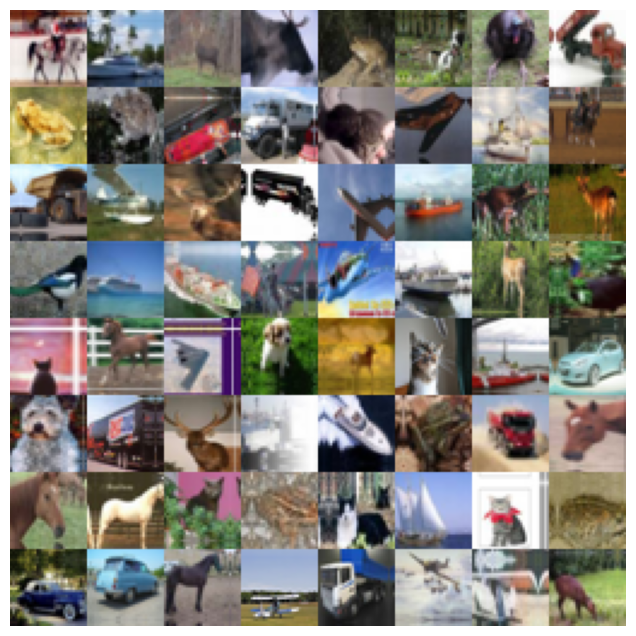

In [8]:
## Fixed Code

import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds  # Required for loading datasets
import flax.linen as nn
from flax.training import train_state
import matplotlib.pyplot as plt
import numpy as np

def load_cifar10(batch_size=64):
    ds = tfds.load('cifar10', split='train', as_supervised=True)

    def preprocess(image, label):
      """Added code to normalize the image output. Please
     note that this is not a specific error. This is added into the
     fixed code to make the output comprehensive"""

      image = tf.image.random_flip_left_right(image)
      # Pad image with 4 pixels on each side using reflection padding
      image = tf.pad(image, [[4, 4], [4, 4], [0, 0]], mode='REFLECT')
      # Random crop a 32x32 image
      image = tf.image.random_crop(image, size=[32, 32, 3])
      # Convert image to float32 and scale to [0, 1]
      image = tf.cast(image, tf.float32) / 255.0
      # Normalize with mean=0.5 and std=0.5 to get values in roughly [-1, 1]
      image = (image - 0.5) / 0.5
      return image, label

      """End of added code"""
      # # Use TensorFlow's image resize function
      # image = tf.image.resize(image, (32, 32))
      # image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
      # return image, label


    ds = ds.map(preprocess)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)  # Improve performance with prefetching

    return tfds.as_numpy(ds)  # // MODIFIED: Convert the dataset to NumPy arrays

def main():
    try:
        batch_size = 64  # Example batch size, adjust as necessary
        cifar10_data = load_cifar10(batch_size)

        # Example of iterating through the dataset and displaying images
        for images, labels in cifar10_data:
            # Show images - this is where you would handle displaying or further processing
            print(images.shape, labels.shape)  # // MODIFIED: Print shapes to show output
            imshow_grid(images)
            break  # Remove break to process all batches

    except Exception as e:
        print("An error occurred:", e)

if __name__ == '__main__':
    main()  # Entry point to the program